In [1]:
import numpy as np
from sklearn.model_selection import KFold
import random
import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms,models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from cnn_finetune import make_model
from sklearn.preprocessing import label_binarize
from itertools import cycle
import seaborn as sns

from sklearn.metrics import auc

from efficientnet_pytorch import EfficientNet

from torchvision import transforms
from torchvision.transforms import InterpolationMode


from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet

In [3]:
# 定数の定義
NUM_CLASSES_CURET = 61  # CUReTデータセットのクラス数を指定します
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 150

In [4]:
# データセットの変換を定義
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# EfficientNetを未学習の状態で初期化
model = EfficientNet.from_name('efficientnet-b0')

model._fc = nn.Linear(model._fc.in_features, NUM_CLASSES_CURET)

# モデルをデバイスに移動
model = model.to(device)

print(model)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [6]:
# CUReTデータセットでの学習
train_dataset_CUReT = torchvision.datasets.ImageFolder(root='/home/yamaguchi/CUReT dataset_png/train')  
valid_dataset_CUReT  = torchvision.datasets.ImageFolder(root='/home/yamaguchi/CUReT dataset_png/valid')   

transform = torchvision.transforms.Compose([
    transforms.Resize((224,224), interpolation=InterpolationMode.BILINEAR),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset_CUReT.transform=transform
valid_dataset_CUReT.transform=transform

train_loader_CUReT = DataLoader(train_dataset_CUReT, BATCH_SIZE, shuffle=False)
valid_loader_CUReT = DataLoader(valid_dataset_CUReT, BATCH_SIZE, shuffle=False)


optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [7]:
def train(device, model, optimizer, criterion, train_loader_CUReT, valid_loader_CUReT, NUM_EPOCHS=300, model_save_path='best_model.pth'):
    model.to(device)
    
    best_valid_acc = 0.0  # 最良の検証精度を追跡するための変数

    for epoch in range(NUM_EPOCHS):
        model.train()  # モデルをトレーニングモードに設定
        
        # Training loop
        running_loss_train = 0.0
        correct_num_train = 0
        total_num_train = 0
        batch_count_train = 0
        
        for data,target in train_loader_CUReT:
            # データをGPUに移動 (もし利用可能な場合)
            inputs, labels = data.to(device), target.to(device)
            
            # 勾配をゼロに設定
            optimizer.zero_grad()
            
            # 順伝播
            outputs = model(inputs)
            
            # 損失の計算
            loss = criterion(outputs, labels)
            predicted = torch.max(outputs.data, 1)[1]
            correct_num_train_temp = (predicted==labels).sum()
            correct_num_train += correct_num_train_temp.item()
            total_num_train += data.shape[0]
            
            # 逆伝播
            loss.backward()
            
            # 重みの更新
            optimizer.step()
            
            # 統計を記録
            running_loss_train += loss.item()
            batch_count_train += 1
        
        print('epoch:%d train loss: %.3f train acc: %.3f' %
             (epoch + 1, running_loss_train / batch_count_train, correct_num_train*100/total_num_train))
        
        # Validation loop
        model.eval()  # モデルを評価モードに設定
#         total_valid_loss = 0
#         total_valid_correct = 0
#         total_valid_samples = 0
        running_loss_valid = 0.0
        correct_num_valid = 0
        total_num_valid = 0
        batch_count_valid = 0
        avg_valid_loss =0
        valid_accuracy=0
        
        
        with torch.no_grad():
            for data,target in valid_loader_CUReT:
                inputs, labels = data.to(device), target.to(device)
                
                # 順伝播
                outputs = model(inputs)
                
                # 損失の計算
                loss = criterion(outputs, labels)
                
                # 統計を記録
#                 _, preds = torch.max(outputs, 1)
#                 total_valid_loss += loss.item()
#                 total_valid_correct += (preds == labels).sum().item()
#                 total_valid_samples += labels.size(0)
                loss = criterion(outputs, labels)
                predicted = torch.max(outputs.data, 1)[1]
                correct_num_valid_temp = (predicted==labels).sum()
                correct_num_valid += correct_num_valid_temp.item()
                total_num_valid += data.shape[0]
                
                
                running_loss_valid += loss.item()
                batch_count_valid += 1
        
        avg_valid_loss = running_loss_valid / batch_count_valid
        valid_accuracy = correct_num_valid*100/total_num_valid
        
        print('epoch:%d valid loss: %.3f valid acc: %.3f' %
             (epoch + 1, avg_valid_loss, valid_accuracy))
        
        
        # 最良の検証精度を持つモデルを保存
        
        if valid_accuracy > best_valid_acc:
            best_valid_acc = valid_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"Improved validation accuracy to {best_valid_acc:.4f}%. Model saved at '{model_save_path}'")

In [8]:
train(device, model, optimizer, criterion, train_loader_CUReT, valid_loader_CUReT, NUM_EPOCHS=150, model_save_path='CUReT.pth')

epoch:1 train loss: 4.627 train acc: 0.448
epoch:1 valid loss: 4.124 valid acc: 2.981
Improved validation accuracy to 2.9808%. Model saved at 'CUReT.pth'
epoch:2 train loss: 4.341 train acc: 0.000
epoch:2 valid loss: 4.897 valid acc: 2.981
epoch:3 train loss: 4.227 train acc: 0.000
epoch:3 valid loss: 8.908 valid acc: 2.981
epoch:4 train loss: 4.190 train acc: 0.008
epoch:4 valid loss: 5.505 valid acc: 2.910
epoch:5 train loss: 4.170 train acc: 0.031
epoch:5 valid loss: 11.526 valid acc: 3.336
Improved validation accuracy to 3.3357%. Model saved at 'CUReT.pth'
epoch:6 train loss: 4.159 train acc: 0.000
epoch:6 valid loss: 8.871 valid acc: 3.052
epoch:7 train loss: 4.144 train acc: 0.100
epoch:7 valid loss: 7.318 valid acc: 3.123
epoch:8 train loss: 4.140 train acc: 0.039
epoch:8 valid loss: 10.089 valid acc: 3.052
epoch:9 train loss: 4.134 train acc: 0.100
epoch:9 valid loss: 12.022 valid acc: 3.194
epoch:10 train loss: 4.128 train acc: 0.070
epoch:10 valid loss: 12.535 valid acc: 3.05

epoch:92 valid loss: 4.762 valid acc: 2.910
epoch:93 train loss: 3.181 train acc: 7.040
epoch:93 valid loss: 4.691 valid acc: 2.910
epoch:94 train loss: 3.116 train acc: 7.372
epoch:94 valid loss: 4.705 valid acc: 2.910
epoch:95 train loss: 3.040 train acc: 8.407
epoch:95 valid loss: 4.769 valid acc: 2.910
epoch:96 train loss: 3.036 train acc: 8.902
epoch:96 valid loss: 4.839 valid acc: 2.910
epoch:97 train loss: 3.045 train acc: 9.211
epoch:97 valid loss: 4.828 valid acc: 2.910
epoch:98 train loss: 2.997 train acc: 10.038
epoch:98 valid loss: 4.935 valid acc: 2.910
epoch:99 train loss: 2.984 train acc: 11.985
epoch:99 valid loss: 4.801 valid acc: 2.910
epoch:100 train loss: 2.924 train acc: 12.341
epoch:100 valid loss: 4.958 valid acc: 2.910
epoch:101 train loss: 2.980 train acc: 12.704
epoch:101 valid loss: 4.767 valid acc: 2.910
epoch:102 train loss: 2.970 train acc: 12.882
epoch:102 valid loss: 4.825 valid acc: 2.910
epoch:103 train loss: 2.892 train acc: 14.017
epoch:103 valid los

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# 保存したモデルのパラメータをロード
model.load_state_dict(torch.load('CUReT.pth', map_location=device)) 

# 新しいタスク用に出力層を変更
model._fc = nn.Linear(model._fc.in_features, 4)


# モデルを適切なデバイスに移動
model = model.to(device)

print(model)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [10]:
#データセットの設定
train_dataset = torchvision.datasets.ImageFolder(root='/home/yamaguchi/最終/GCB Non-GCB MALT Normal -最終/train')  #学習用データ：データ数は560
test_dataset  = torchvision.datasets.ImageFolder(root='/home/yamaguchi/最終/GCB Non-GCB MALT Normal -最終/test') 

transform = torchvision.transforms.Compose([
    transforms.RandomCrop((224,224)),
    # ランダムに画像を水平方向に反転
    transforms.RandomHorizontalFlip(),
    # ランダムに画像の色調を変更
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    # グレースケールに変換（3チャンネル出力）
    transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_2 = torchvision.transforms.Compose([
    transforms.RandomCrop((224,224)),
    # グレースケールに変換（3チャンネル出力）
    transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


batch_size = 32

train_dataset.transform=transform
test_dataset.transform=transform_2
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

print(train_dataset.classes)


['1 normal', '2 MALT', '3 GCB', '4 Non-GCB']


In [11]:
from torchsummary import summary

summary(model, (3, 224, 224))

#https://discuss.pytorch.org/t/what-is-1-in-output-shape-of-a-model-in-torch-summary/67790

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
MemoryEfficientSwish-4         [-1, 32, 112, 112]               0
         ZeroPad2d-5         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
MemoryEfficientSwish-8         [-1, 32, 112, 112]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

In [12]:
# Train

def train(device, model, optimizer, criterion, cv_train_dataloader, cv_valid_dataloader):
    # Early stoppingの設定
    the_last_loss = 100  
    patience = 10
    trigger_times = 0

    for epoch in range(100):
        model.train()
        running_loss = 0.0
        correct_num = 0
        total_num = 0
        batch_count = 0

        for data,target in  cv_train_dataloader:
            inputs, labels = data.to(device), target.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            predicted = torch.max(outputs.data, 1)[1]
            correct_num_temp = (predicted==labels).sum()
            correct_num += correct_num_temp.item()
            total_num += data.shape[0]
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch_count += 1 

        print('epoch:%d loss: %.3f acc: %.3f' %
             (epoch + 1, running_loss / batch_count, correct_num*100/total_num))
            

        # Early stopping
        the_current_loss = validation(model, device, cv_valid_dataloader, criterion)
        print('The current loss:', the_current_loss)

        if the_current_loss > the_last_loss:
            trigger_times += 1
            print('trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                return model

        else:
            print('trigger times: 0')
            trigger_times = 0

        the_last_loss = the_current_loss

    return model

In [13]:
#validation

def validation(model, device, cv_valid_dataloader, criterion):
    model.eval()
    running_loss = 0

    with torch.no_grad():
        for data,target in cv_valid_dataloader:
            inputs, labels = data.to(device), target.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    return running_loss / len(cv_valid_dataloader)#

In [14]:

def test(device, model, test_dataloader):
    model.eval()
    
    correct_num = 0
    total_num = 0
    predicts_list = []
    labels_list = []
    scores_list=[] 

    with torch.no_grad():
        for data, target in test_dataloader:
            inputs, labels = data.to(device), target.to(device)

            outputs = model(inputs)
            m = nn.Softmax(dim=1)
            probs = m(outputs)
            
            _, predicted = torch.max(outputs.data, 1)
            correct_num_temp = (predicted == labels).sum()
            correct_num += correct_num_temp.item()
            total_num += data.shape[0]

            device2 = torch.device('cpu')
            labels=labels.to(device2)
            predicted = predicted.to(device2)
            probs = probs.to(device2)

            labels_list.append(labels)
            predicts_list.append(predicted)
            scores_list.append(probs)  
    
        labels = torch.cat(labels_list)
        predicted = torch.cat(predicts_list)
        scores = torch.cat(scores_list)  

        labels_bin = label_binarize(labels, classes=[0, 1, 2, 3])  # Changed to four classes

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(4):  # Changed loop range to four classes
            fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], scores[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        C = confusion_matrix(labels, predicted)
        ac = accuracy_score(labels, predicted)
        pre = precision_score(labels, predicted, average='macro')
        re = recall_score(labels, predicted, average='macro')
        f1 = f1_score(labels, predicted, average='macro')

        AUC = roc_auc_score(labels, scores, multi_class='ovr')  

        print(C)
        print("\n")
        print("test accuracy : %.3f" % ac)
        print("test precison : %.3f" % pre)
        print("test recall : %.3f" % re)
        print("test f : %.3f" % f1)
        print("AUC : %.3f" %(AUC))

        for i in range(4):  # Changed loop range to four classes
            print("AUC for class {}: {:.3f}".format(i, roc_auc[i]))

        # Compute macro-average ROC curve and ROC area
        fpr_macro = dict()
        tpr_macro = dict()
        roc_auc_macro = dict()
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))  # Changed loop range to four classes
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(4):  # Changed loop range to four classes
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= 4  # Changed the denominator to four classes
        fpr_macro["macro"] = all_fpr
        tpr_macro["macro"] = mean_tpr
        roc_auc_macro["macro"] = auc(fpr_macro["macro"], tpr_macro["macro"])

        # Plot all ROC curves
        plt.figure()
        plt.plot(fpr_macro["macro"], tpr_macro["macro"],
                 label='macro-average ROC curve (area = {:.3g})'.format(roc_auc_macro["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])  # Added one more color for the additional class
        class_labels = ['normal lymph nodes', 'MALToma', 'GCB', 'non-GCB']  # Changed to four class labels
        for i, color in zip(range(4), colors):  # Changed loop range to four classes
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label='ROC curve of class {0} (area = {1:.3g})'
                     ''.format(class_labels[i], roc_auc[i]))

            
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        
        class_labels = ['normal lymph nodes', 'MALToma', 'GCB', 'non-GCB']   # Changed to four class labels
        C = confusion_matrix(labels, predicted)

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(C, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels,annot_kws={'size': 20})
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
        plt.show()

            

In [15]:
#k分割交差検証

kf = KFold(n_splits=10)

Fold 1------------------------------------------------------------------------------
epoch:1 loss: 1.251 acc: 50.171
The current loss: 1.2356605972863932
trigger times: 0
epoch:2 loss: 1.201 acc: 51.038
The current loss: 1.1525522626958413
trigger times: 0
epoch:3 loss: 1.064 acc: 54.094
The current loss: 1.0127150407747796
trigger times: 0
epoch:4 loss: 0.970 acc: 57.389
The current loss: 0.9091314292927671
trigger times: 0
epoch:5 loss: 0.929 acc: 59.937
The current loss: 0.8889672722788335
trigger times: 0
epoch:6 loss: 0.910 acc: 60.870
The current loss: 0.9076755509813451
trigger times: 1
epoch:7 loss: 0.870 acc: 62.070
The current loss: 0.8495515517362978
trigger times: 0
epoch:8 loss: 0.844 acc: 63.094
The current loss: 0.8328371024786723
trigger times: 0
epoch:9 loss: 0.834 acc: 63.676
The current loss: 0.8382684092606063
trigger times: 1
epoch:10 loss: 0.816 acc: 64.359
The current loss: 0.8837765768434094
trigger times: 2
epoch:11 loss: 0.793 acc: 65.420
The current loss: 0.7

The current loss: 0.20523887873616686
trigger times: 0
epoch:95 loss: 0.180 acc: 93.058
The current loss: 0.1860669108235949
trigger times: 0
epoch:96 loss: 0.188 acc: 93.243
The current loss: 0.10418697022859437
trigger times: 0
epoch:97 loss: 0.183 acc: 93.160
The current loss: 0.08132960333405262
trigger times: 0
epoch:98 loss: 0.177 acc: 93.427
The current loss: 0.2041740456438852
trigger times: 1
epoch:99 loss: 0.176 acc: 93.178
The current loss: 0.09384840102791493
trigger times: 0
epoch:100 loss: 0.167 acc: 93.714
The current loss: 0.16634394108237693
trigger times: 1
[[ 92  14   0  44]
 [  0  62  25  35]
 [  0   8  63 139]
 [  2  27  83 368]]


test accuracy : 0.608
test precison : 0.633
test recall : 0.547
test f : 0.577
AUC : 0.806
AUC for class 0: 0.944
AUC for class 1: 0.927
AUC for class 2: 0.638
AUC for class 3: 0.716


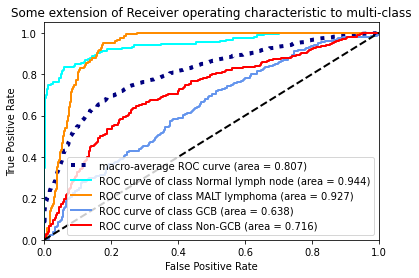

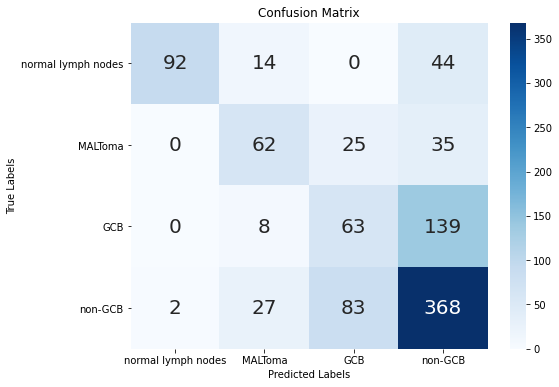

Fold 2------------------------------------------------------------------------------
epoch:1 loss: 1.253 acc: 50.282
The current loss: 1.3599852743753642
trigger times: 0
epoch:2 loss: 1.196 acc: 51.075
The current loss: 1.1495099243512898
trigger times: 0
epoch:3 loss: 1.048 acc: 54.657
The current loss: 0.9673172038180374
trigger times: 0
epoch:4 loss: 0.958 acc: 57.999
The current loss: 0.9570468574196408
trigger times: 0
epoch:5 loss: 0.925 acc: 59.466
The current loss: 0.8845112710136228
trigger times: 0
epoch:6 loss: 0.893 acc: 60.196
The current loss: 0.8837343332107703
trigger times: 0
epoch:7 loss: 0.867 acc: 62.023
The current loss: 0.8423358832587623
trigger times: 0
epoch:8 loss: 0.849 acc: 62.697
The current loss: 0.9499343938666744
trigger times: 1
epoch:9 loss: 0.822 acc: 64.045
The current loss: 0.7447271506442169
trigger times: 0
epoch:10 loss: 0.808 acc: 64.507
The current loss: 0.7485829855818137
trigger times: 1
epoch:11 loss: 0.800 acc: 64.654
The current loss: 0.7

epoch:94 loss: 0.179 acc: 92.994
The current loss: 0.16546415177459456
trigger times: 0
epoch:95 loss: 0.175 acc: 93.391
The current loss: 0.09582939814930888
trigger times: 0
epoch:96 loss: 0.174 acc: 93.547
The current loss: 0.19645768898981072
trigger times: 1
epoch:97 loss: 0.173 acc: 93.612
The current loss: 0.12229919713715436
trigger times: 0
epoch:98 loss: 0.181 acc: 93.381
The current loss: 0.19710359847612755
trigger times: 1
epoch:99 loss: 0.167 acc: 93.769
The current loss: 0.16344491968564956
trigger times: 0
epoch:100 loss: 0.174 acc: 93.354
The current loss: 0.07131300880044252
trigger times: 0
[[ 97  20   0  33]
 [  0  74  20  28]
 [  0   4  45 161]
 [  0  20  59 401]]


test accuracy : 0.641
test precison : 0.658
test recall : 0.576
test f : 0.600
AUC : 0.797
AUC for class 0: 0.956
AUC for class 1: 0.927
AUC for class 2: 0.581
AUC for class 3: 0.725


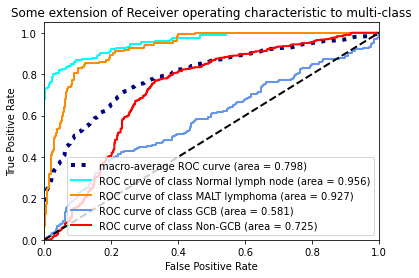

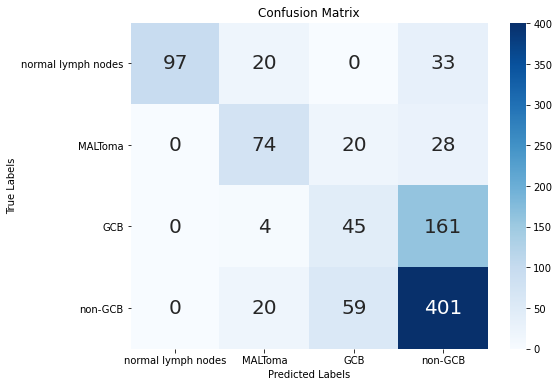

Fold 3------------------------------------------------------------------------------
epoch:1 loss: 1.250 acc: 49.857
The current loss: 1.284314144501644
trigger times: 0
epoch:2 loss: 1.202 acc: 51.112
The current loss: 1.186102635916707
trigger times: 0
epoch:3 loss: 1.082 acc: 53.540
The current loss: 0.9664708183402508
trigger times: 0
epoch:4 loss: 0.967 acc: 57.925
The current loss: 0.9538031977609591
trigger times: 0
epoch:5 loss: 0.924 acc: 59.910
The current loss: 0.9219837743887859
trigger times: 0
epoch:6 loss: 0.900 acc: 60.500
The current loss: 0.850585270895565
trigger times: 0
epoch:7 loss: 0.876 acc: 61.590
The current loss: 0.845636911855071
trigger times: 0
epoch:8 loss: 0.839 acc: 63.085
The current loss: 0.8324366354982432
trigger times: 0
epoch:9 loss: 0.829 acc: 63.833
The current loss: 0.7573983954282197
trigger times: 0
epoch:10 loss: 0.804 acc: 64.220
The current loss: 0.7752101433856253
trigger times: 1
epoch:11 loss: 0.790 acc: 65.199
The current loss: 0.78438

The current loss: 0.10562822094310467
trigger times: 0
epoch:95 loss: 0.179 acc: 93.160
The current loss: 0.1119871189893778
trigger times: 1
epoch:96 loss: 0.179 acc: 93.455
The current loss: 0.11739916501745076
trigger times: 2
epoch:97 loss: 0.175 acc: 93.400
The current loss: 0.19139096675540837
trigger times: 3
epoch:98 loss: 0.164 acc: 93.972
The current loss: 0.12674975778359743
trigger times: 0
epoch:99 loss: 0.153 acc: 94.526
The current loss: 0.10847266224735419
trigger times: 0
epoch:100 loss: 0.159 acc: 94.018
The current loss: 0.06977892378189418
trigger times: 0
[[ 87  13   0  50]
 [  0  60  11  51]
 [  0  11  45 154]
 [  3  19  92 366]]


test accuracy : 0.580
test precison : 0.611
test recall : 0.512
test f : 0.544
AUC : 0.790
AUC for class 0: 0.948
AUC for class 1: 0.932
AUC for class 2: 0.604
AUC for class 3: 0.674


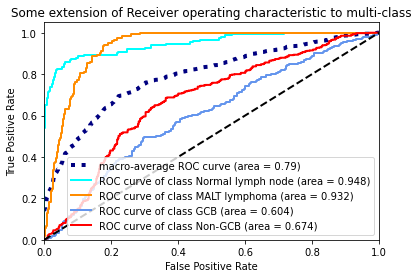

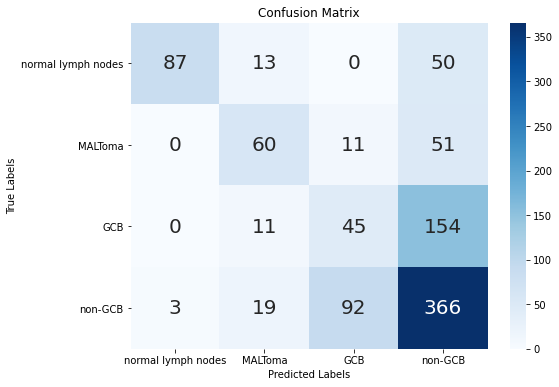

Fold 4------------------------------------------------------------------------------
epoch:1 loss: 1.254 acc: 49.358
The current loss: 1.3048435257951068
trigger times: 0
epoch:2 loss: 1.216 acc: 50.549
The current loss: 1.1967448564053988
trigger times: 0
epoch:3 loss: 1.110 acc: 52.599
The current loss: 1.029452247231935
trigger times: 0
epoch:4 loss: 0.995 acc: 56.282
The current loss: 0.9030441632576748
trigger times: 0
epoch:5 loss: 0.945 acc: 58.479
The current loss: 0.8798721564994098
trigger times: 0
epoch:6 loss: 0.910 acc: 60.140
The current loss: 0.8612314188374882
trigger times: 0
epoch:7 loss: 0.887 acc: 60.962
The current loss: 0.932788599831956
trigger times: 1
epoch:8 loss: 0.861 acc: 62.014
The current loss: 0.8149837596688123
trigger times: 0
epoch:9 loss: 0.845 acc: 62.679
The current loss: 0.9089176388001372
trigger times: 1
epoch:10 loss: 0.834 acc: 63.030
The current loss: 0.8589474015641178
trigger times: 0
epoch:11 loss: 0.807 acc: 64.922
The current loss: 0.798

The current loss: 0.18119498035355364
trigger times: 1
epoch:95 loss: 0.176 acc: 93.317
The current loss: 0.1444946757262635
trigger times: 0
epoch:96 loss: 0.171 acc: 93.501
The current loss: 0.09688302430319888
trigger times: 0
epoch:97 loss: 0.163 acc: 93.751
The current loss: 0.1607882030286746
trigger times: 1
epoch:98 loss: 0.173 acc: 93.437
The current loss: 0.18727174120389178
trigger times: 2
epoch:99 loss: 0.159 acc: 93.898
The current loss: 0.06906127134686377
trigger times: 0
epoch:100 loss: 0.172 acc: 93.621
The current loss: 0.07956113423646576
trigger times: 1
[[ 79   9   2  60]
 [  0  40  38  44]
 [  1   5  56 148]
 [  2   4  86 388]]


test accuracy : 0.585
test precison : 0.642
test recall : 0.482
test f : 0.526
AUC : 0.791
AUC for class 0: 0.966
AUC for class 1: 0.934
AUC for class 2: 0.556
AUC for class 3: 0.709


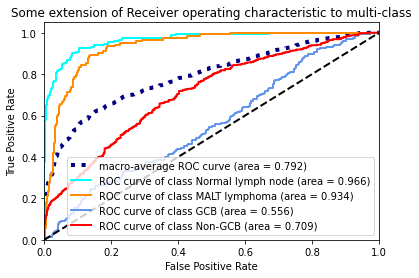

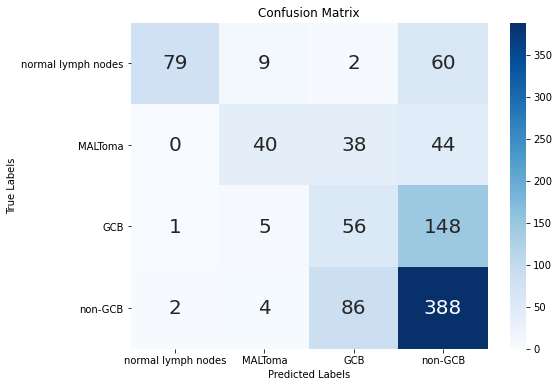

Fold 5------------------------------------------------------------------------------
epoch:1 loss: 1.251 acc: 50.355
The current loss: 1.249778816130309
trigger times: 0
epoch:2 loss: 1.197 acc: 50.762
The current loss: 1.1631683076904937
trigger times: 0
epoch:3 loss: 1.065 acc: 53.900
The current loss: 1.008612482212374
trigger times: 0
epoch:4 loss: 0.970 acc: 57.029
The current loss: 0.8948383857674655
trigger times: 0
epoch:5 loss: 0.928 acc: 59.476
The current loss: 0.9978625834164014
trigger times: 1
epoch:6 loss: 0.907 acc: 60.039
The current loss: 0.8753524323963837
trigger times: 0
epoch:7 loss: 0.875 acc: 61.257
The current loss: 0.8091442701008423
trigger times: 0
epoch:8 loss: 0.857 acc: 62.300
The current loss: 0.966494501516179
trigger times: 1
epoch:9 loss: 0.836 acc: 63.103
The current loss: 0.8380526265123952
trigger times: 0
epoch:10 loss: 0.817 acc: 64.562
The current loss: 0.8202852875414609
trigger times: 0
epoch:11 loss: 0.803 acc: 64.525
The current loss: 0.7398

KeyboardInterrupt: 

In [16]:
%%time

def main():
    
    for _fold, (train_index, valid_index) in enumerate(kf.split(np.arange(len(train_dataset)))):
    
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        model = EfficientNet.from_name('efficientnet-b0')
        
        model._fc = nn.Linear(model._fc.in_features, NUM_CLASSES_CURET)
        # 保存したモデルのパラメータをロード
        model.load_state_dict(torch.load('CUReT.pth', map_location=device)) 

        # 新しいタスク用に出力層を変更
        model._fc = nn.Linear(model._fc.in_features, 4)


        # モデルを適切なデバイスに移動
        model = model.to(device)

        batch_size = 32
        criterion = nn.CrossEntropyLoss()
        # Pass all model parameters to the optimizer
        optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9) # Optimize the entire model for fine-tuning
        
        cv_train_dataset = Subset(train_dataset, train_index)
        cv_train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
        cv_valid_dataset   = Subset(train_dataset, valid_index)
        cv_valid_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)
        
        print('Fold {}------------------------------------------------------------------------------'.format(_fold+1))

        model = train(device, model, optimizer, criterion, cv_train_dataloader, cv_valid_dataloader)
        test(device, model, test_dataloader)


if __name__ == '__main__':
    main()